# Group 20 — Exploratory Data Analysis
This notebook performs an initial exploratory data analysis (EDA) on the provided customer and flights databases.
The goals are:
- Inspect imports and data quality
- Identify missing or strange values
- Preprocess data for downstream modeling

## Table of contents
- [Import data](#import-data)
- [Data Exploration](#data-exploration)
  - [Customer DB](#customer-db)
    - [Inspect import](#inspect-import-customer)
    - [Check categorical values](#check-cat-values-customer)
    - [Check Outliers](#check-outliers)
  - [Flights DB](#flights-db)
    - [Inspect import](#inspect-import-flights)
    - [Check Outliers](#check-outliers-flight)
- [Preprocessing](#preprocessing)
  - [Missing Values](#missing-values)
  - [Convert data types](#convert-data-types)

# <a id="import-data"></a> Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats

# Load the data

customer_db = pd.read_csv("data/DM_AIAI_CustomerDB.csv", index_col=0 )
flights_db = pd.read_csv("data/DM_AIAI_FlightsDB.csv")


# <a id="data-exploration"></a> Data Exploration

### <a id="customer-db"></a> Customer DB

#### <a id="inspect-import-customer"></a> Inspect import

In [2]:
customer_db.head()

,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,NaN,3839.14,Standard
1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,male,College,Rural,0.0,Divorced,Star,3/9/2019,NaN,3839.61,Standard
2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard
3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,male,College,Suburban,0.0,Single,Star,2/17/2016,NaN,3839.75,Standard
4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,male,Bachelor,Suburban,97832.0,Married,Star,10/25/2017,NaN,3842.79,2021 Promotion


In [3]:
customer_db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16921 entries, 0 to 19
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Loyalty#                 16921 non-null  int64  
 1   First Name               16921 non-null  object 
 2   Last Name                16921 non-null  object 
 3   Customer Name            16921 non-null  object 
 4   Country                  16921 non-null  object 
 5   Province or State        16921 non-null  object 
 6   City                     16921 non-null  object 
 7   Latitude                 16921 non-null  float64
 8   Longitude                16921 non-null  float64
 9   Postal code              16921 non-null  object 
 10  Gender                   16921 non-null  object 
 11  Education                16921 non-null  object 
 12  Location Code            16921 non-null  object 
 13  Income                   16901 non-null  float64
 14  Marital Status           16921

In [4]:
duplicated_loyalty_ids = customer_db[customer_db['Loyalty#'].duplicated()]['Loyalty#'].unique()
print(f"Number of unique Duplicated Loyalty IDs: {len(duplicated_loyalty_ids)}")

Number of unique Duplicated Loyalty IDs: 163


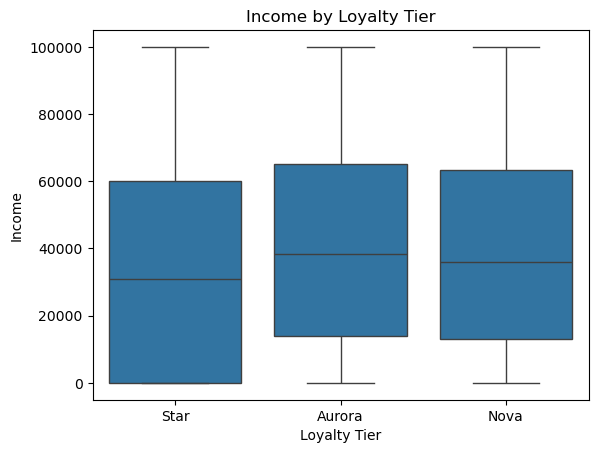

In [5]:
sns.boxplot(x='LoyaltyStatus', y='Income', data=customer_db.dropna(subset=['Income']))
plt.title('Income by Loyalty Tier')
plt.xlabel('Loyalty Tier')
plt.ylabel('Income')
plt.show()

In [6]:
customer_db.groupby('LoyaltyStatus')['Income'].agg(['count', 'mean', 'median'])

,count,mean,median
LoyaltyStatus,,,
Aurora,3438,40207.368528,38433.5
Nova,5722,38934.271409,36091.0
Star,7741,35800.771606,30817.0


In [7]:

groups = [group["Income"].dropna() for _, group in customer_db.groupby("Education")]
f_stat, p_val = stats.f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_val:.4f}")

ANOVA F-statistic: 8453.611, p-value: 0.0000


#### <a id="check-cat-values-customer"></a> Check categorical values

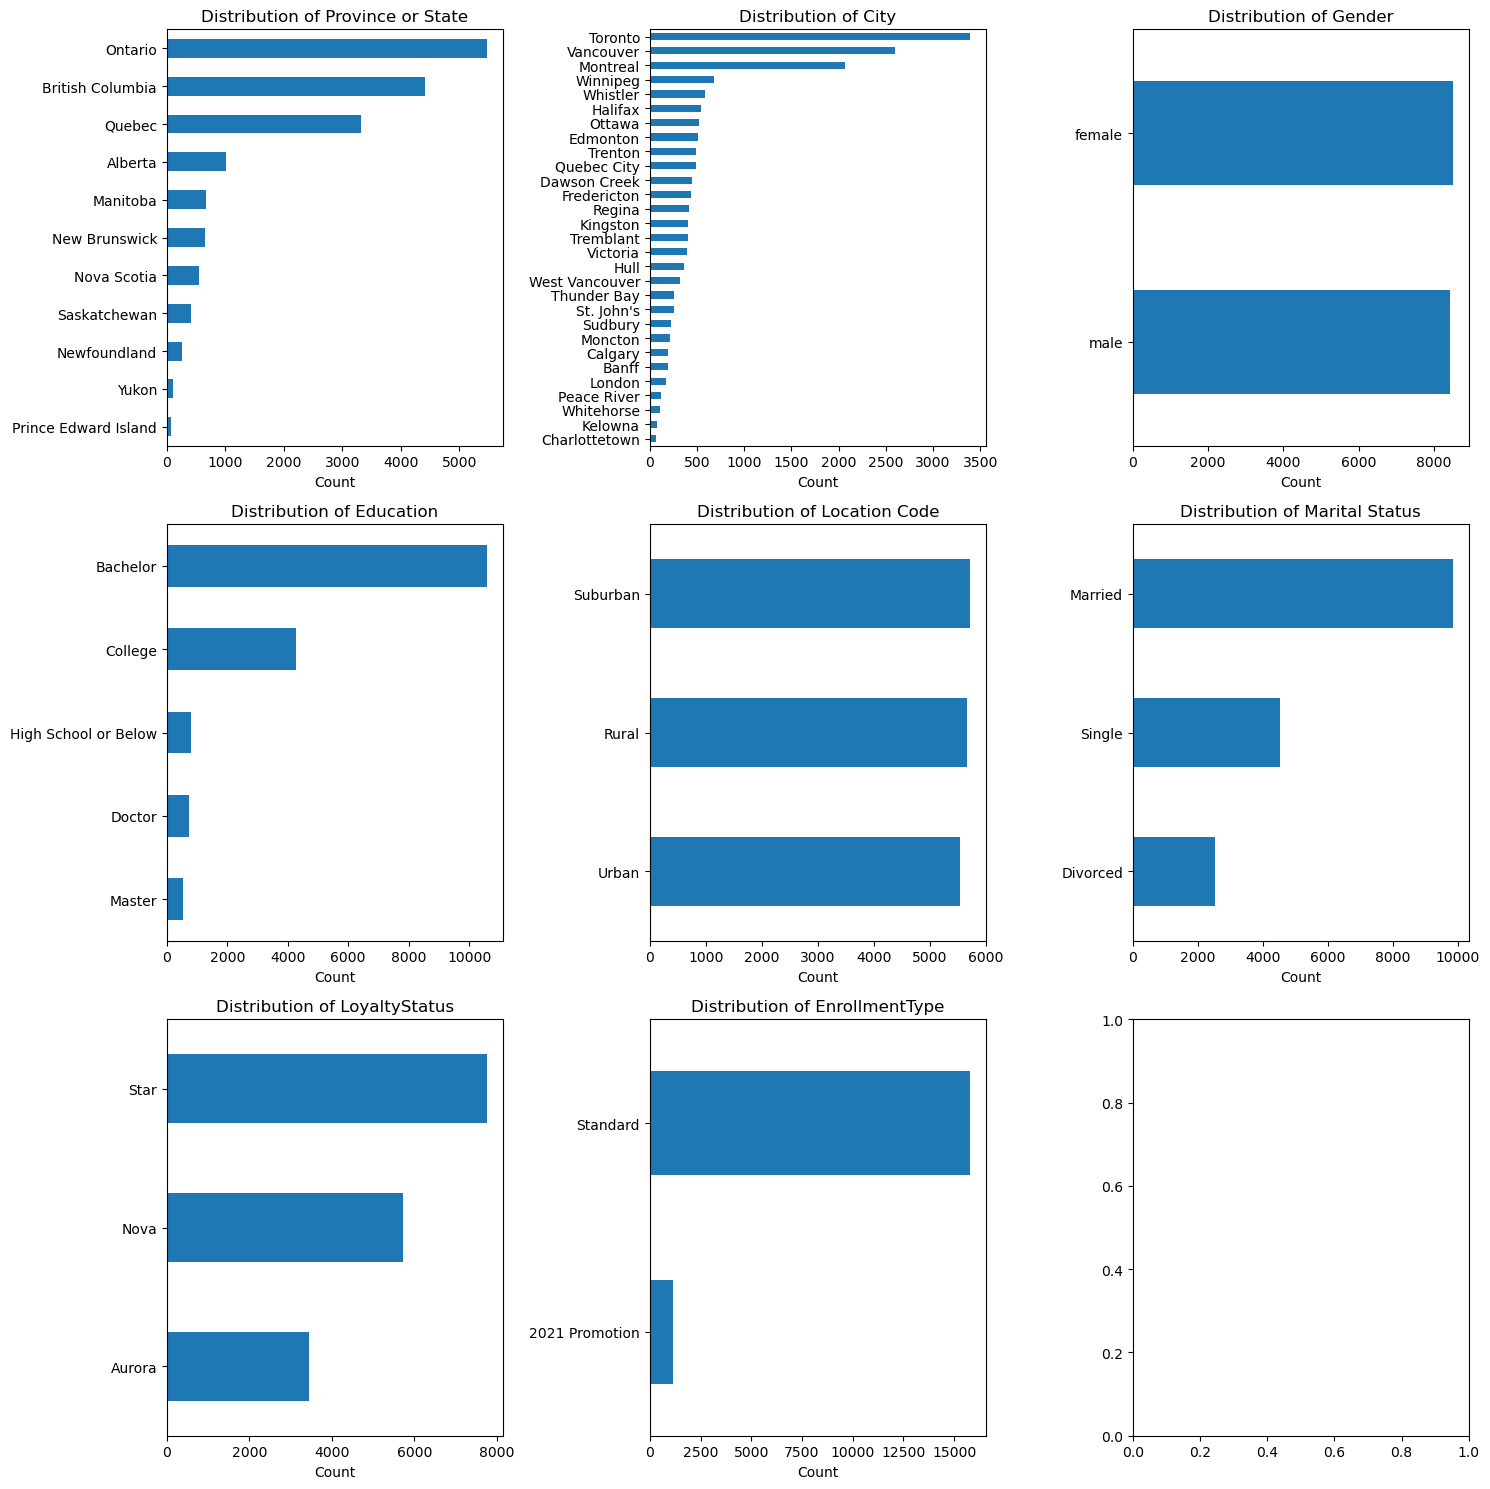

In [8]:
categorical_cols = [
     'Province or State', 'City', 'Gender', 'Education',
    'Location Code', 'Marital Status', 'LoyaltyStatus', 'EnrollmentType'
]

# Create the figure and axes
fig, axes = plt.subplots(
    nrows=math.ceil(len(categorical_cols) / 3),
    ncols=3,
    figsize=(15, 15)
)
# TODO: remove Country subplot

# Generate a plot for each categorical column
for ax, col in zip(axes.flatten(), categorical_cols):
    customer_db[col].value_counts().plot(
        kind='barh',
        ax=ax,
        title=f'Distribution of {col}'
    )
    ax.set_xlabel("Count")
    ax.set_ylabel("")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

### Scatter Plot for the customer dataset


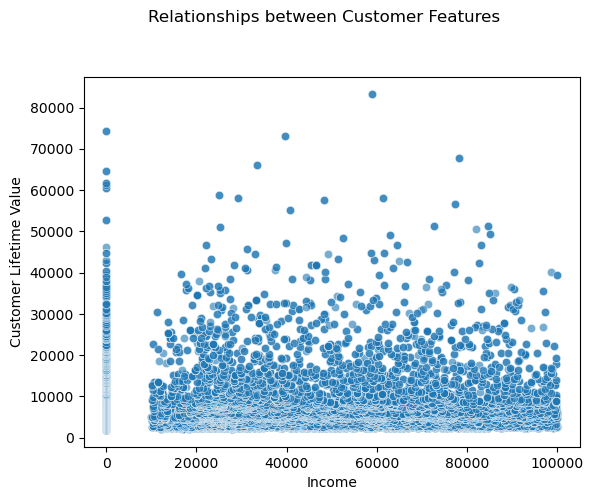

In [9]:
numeric_features = ['Income', 'Customer Lifetime Value']

customer_db_reset = customer_db.reset_index()

sns.scatterplot(
    data=customer_db_reset,
    x='Income',        
    y='Customer Lifetime Value',
    alpha=0.6
)

plt.suptitle('Relationships between Customer Features', y=1.02)
plt.show()

### Observations from the scatter plot

- **No clear linear relationship:** Income and Customer Lifetime Value don't have a strong correlation, given the fact that the points are widely scattered across all income levels, suggesting that higher income doesn't necessarily imply an higher customer lifetime value.

- **Cluster of low-income customers:** There is a noticeable dense cluster of data points near Income = 0, indicating that a large portion of customers have very low (or missing) income values, probably bachelor students

- **High Variance in Customer Lifetime Value:** Across all income ranges, the CLV varies greatly — some customers with low income have high CLV, and vice versa. This suggests that factors other than income likely play a more important role in determining CLV.


### <a id="check-outliers"></a> Check Outliers

In [10]:

numeric_features = ["Income", "Customer Lifetime Value"]


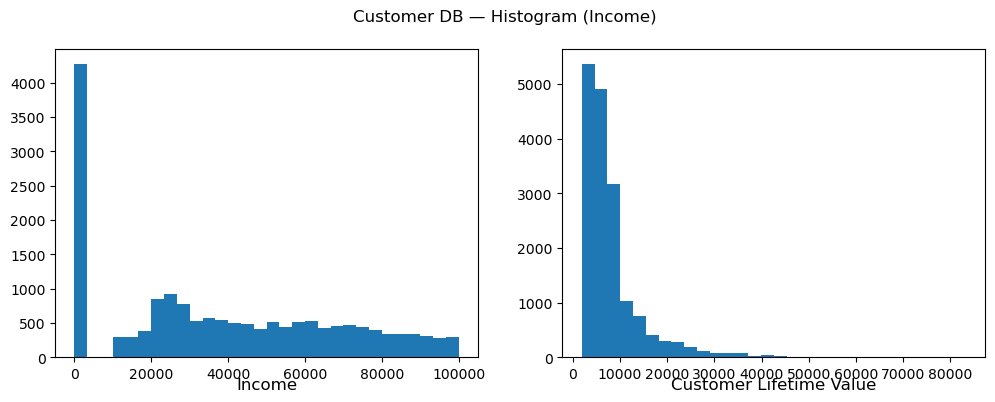

In [11]:
#checking the histogram of income and customer lifetime value
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat in zip(np.atleast_1d(axes).flatten(), numeric_features):
    ax.hist(customer_db[feat].dropna(), bins=30)
    ax.set_title(feat, y=-0.13)

plt.suptitle("Customer DB — Histogram (Income)")
plt.show()

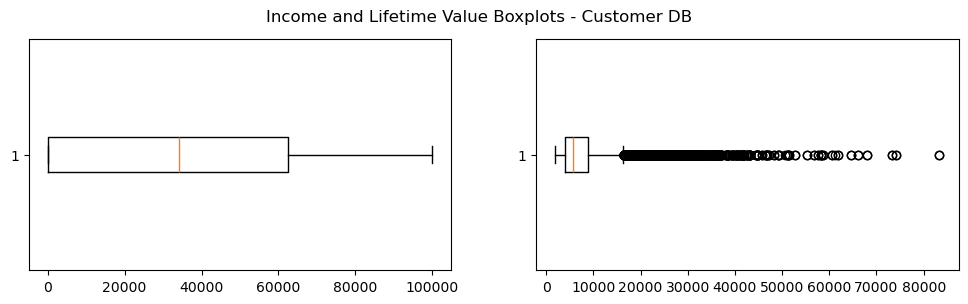

In [12]:
#TODO : label box plots correctly

#checking boxplot for income and customer lifetime value
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

for ax, feat in zip(np.atleast_1d(axes).ravel(), numeric_features):
    ax.boxplot(customer_db[feat].dropna().values, vert=False)

plt.suptitle("Income and Lifetime Value Boxplots - Customer DB")
plt.show()

In [13]:
missing_cust = customer_db.isna().sum()
display(pd.DataFrame({
    'Missing Count': missing_cust[missing_cust > 0],
    '%': (missing_cust[missing_cust > 0] / len(customer_db) * 100).round(2)
}))

,Missing Count,%
Income,20,0.12
CancellationDate,14611,86.35
Customer Lifetime Value,20,0.12


### <a id="flights-db"></a> Flights DB

#### <a id="inspect-import-flights"></a> Inspect import

In [14]:
flights_db.head()

,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
0,413052,2021,12,12/1/2021,2.0,2.0,9384.0,938.0,0.0,0.0
1,464105,2021,12,12/1/2021,0.0,0.0,0.0,0.0,0.0,0.0
2,681785,2021,12,12/1/2021,10.0,3.0,14745.0,1474.0,0.0,0.0
3,185013,2021,12,12/1/2021,16.0,4.0,26311.0,2631.0,3213.0,32.0
4,216596,2021,12,12/1/2021,9.0,0.0,19275.0,1927.0,0.0,0.0


In [15]:
flights_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608436 entries, 0 to 608435
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Loyalty#                  608436 non-null  int64  
 1   Year                      608436 non-null  int64  
 2   Month                     608436 non-null  int64  
 3   YearMonthDate             608436 non-null  object 
 4   NumFlights                608436 non-null  float64
 5   NumFlightsWithCompanions  608436 non-null  float64
 6   DistanceKM                608436 non-null  float64
 7   PointsAccumulated         608436 non-null  float64
 8   PointsRedeemed            608436 non-null  float64
 9   DollarCostPointsRedeemed  608436 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 46.4+ MB


### <a id="check-outliers-flight"></a> Check Outliers

In [16]:
numeric_features = [
    "NumFlights",
    "NumFlightsWithCompanions",
    "DistanceKM",
    "PointsAccumulated",
    "PointsRedeemed",
    "DollarCostPointsRedeemed"
]


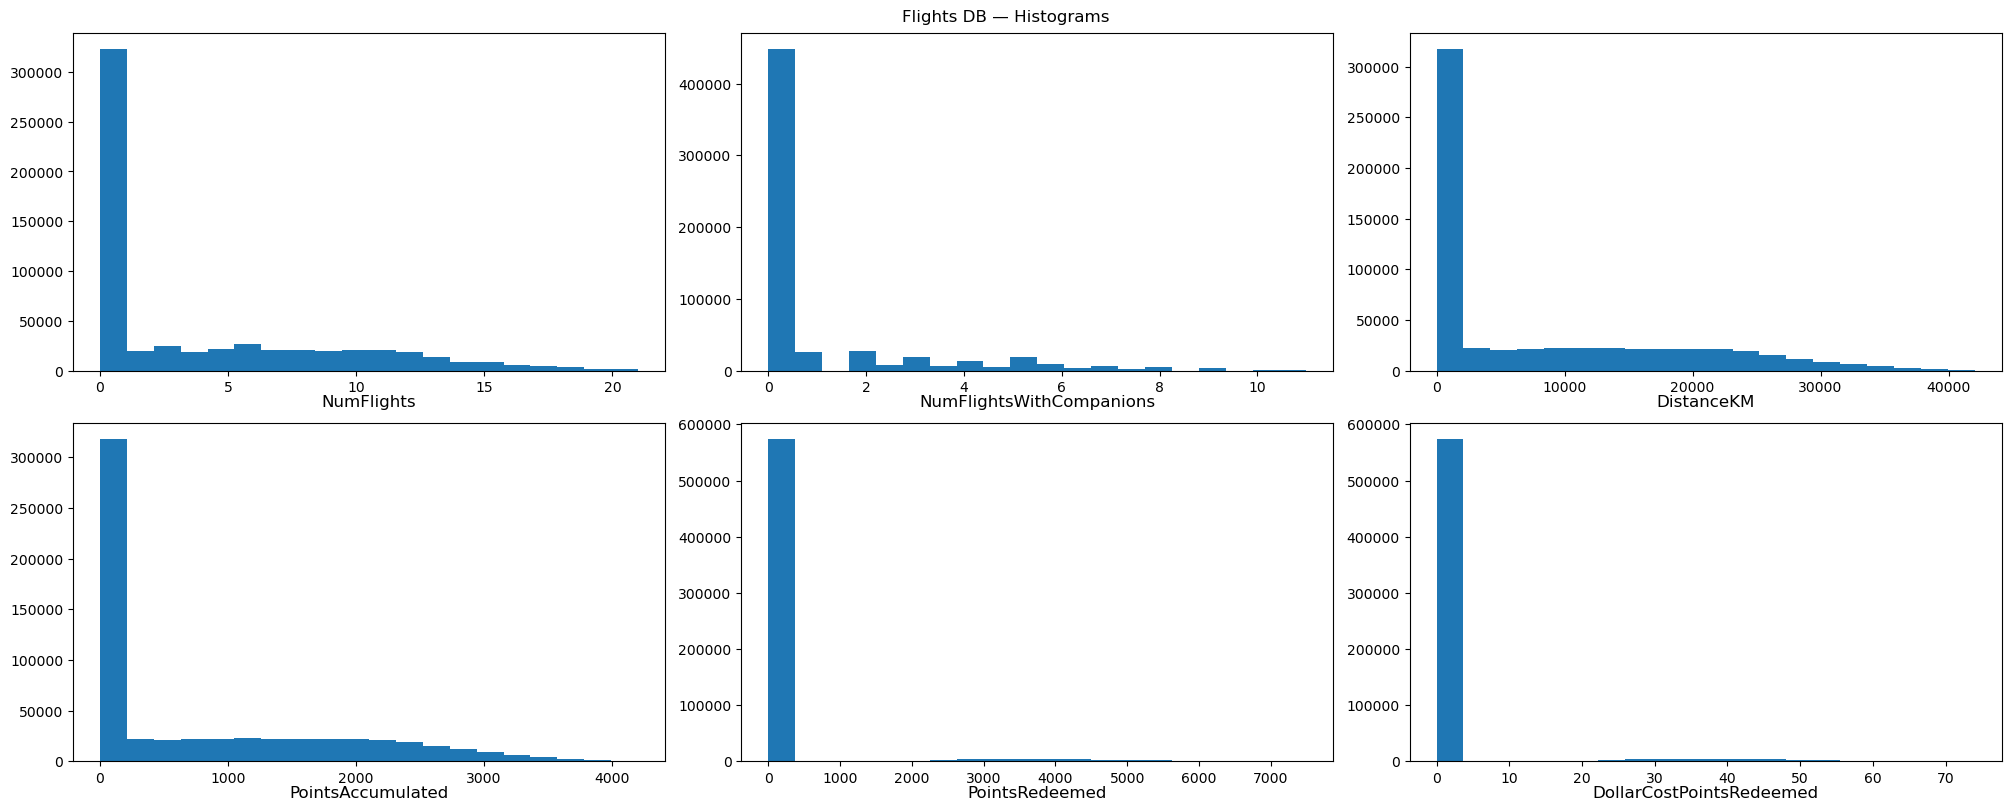

In [17]:
# TODO : Use bar plots for discrete values
fig, axes = plt.subplots(2, 3, figsize=(20, 8), constrained_layout=True)

for ax, feat in zip(axes.flatten(), numeric_features):
    ax.hist(flights_db[feat].dropna(), bins=20)
    ax.set_title(feat, y=-0.13)

plt.suptitle("Flights DB — Histograms")
plt.show()

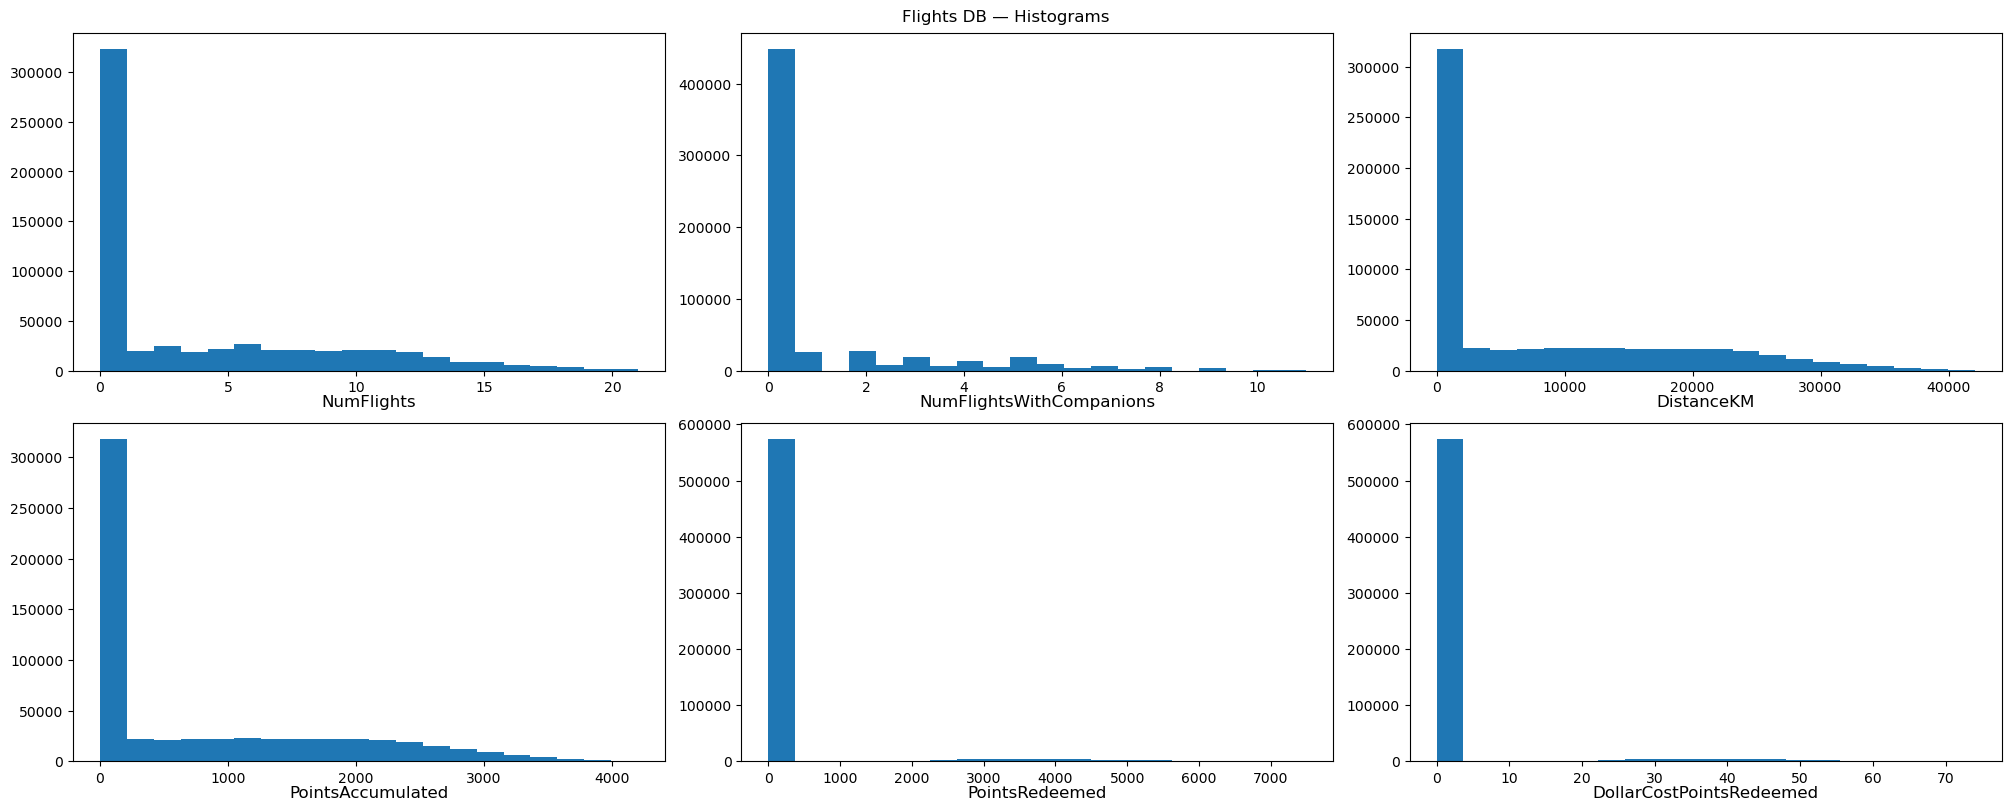

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8), constrained_layout=True)

for ax, feat in zip(axes.flatten(), numeric_features):
    ax.hist(flights_db[feat].dropna(), bins=20)
    ax.set_title(feat, y=-0.13)

plt.suptitle("Flights DB — Histograms")
plt.show()



In [19]:
#checking to see if there are float flights or float flight companions 
invalid_fractional_flights = flights_db[
    (flights_db['NumFlights'] % 1 != 0) |
    (flights_db['NumFlightsWithCompanions'] % 1 != 0)
]

print(f"Number of rows with impossible fractional flight counts: {len(invalid_fractional_flights)}")
if not invalid_fractional_flights.empty:
    display(invalid_fractional_flights[[ 'Year', 'Month', 'NumFlights', 'NumFlightsWithCompanions']].head(10))

Number of rows with impossible fractional flight counts: 93055


,Year,Month,NumFlights,NumFlightsWithCompanions
405624,2019,1,2.7,0.0
405625,2019,1,9.0,3.6
405626,2019,1,5.4,0.0
405632,2019,1,5.4,0.0
405634,2019,1,2.7,0.0
405635,2019,1,9.0,1.8
405640,2019,1,9.9,0.0
405642,2019,1,7.2,3.6
405643,2019,1,8.1,0.9
405644,2019,1,5.4,5.4


In [20]:
#checking to see if there are any individuals that were not on a flight but their recorded distance was >0
invalid_flights = flights_db[(flights_db['NumFlights'] == 0) & (flights_db['DistanceKM'] > 0)]

print(f"Number of inconsistent rows (NumFlights=0 & DistanceKM>0): {len(invalid_flights)}")
if not invalid_flights.empty:
    display(invalid_flights.head())

Number of inconsistent rows (NumFlights=0 & DistanceKM>0): 5901


,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
19,261109,2021,12,12/1/2021,0.0,0.0,13736.0,1373.0,0.0,0.0
93,817609,2021,12,12/1/2021,0.0,0.0,23775.0,2377.0,0.0,0.0
96,192600,2021,12,12/1/2021,0.0,0.0,5119.0,511.0,0.0,0.0
116,883242,2021,12,12/1/2021,0.0,0.0,20681.0,2068.0,0.0,0.0
154,493800,2021,12,12/1/2021,0.0,0.0,17502.0,1750.0,0.0,0.0


### Scatter Plots for the flights dataset

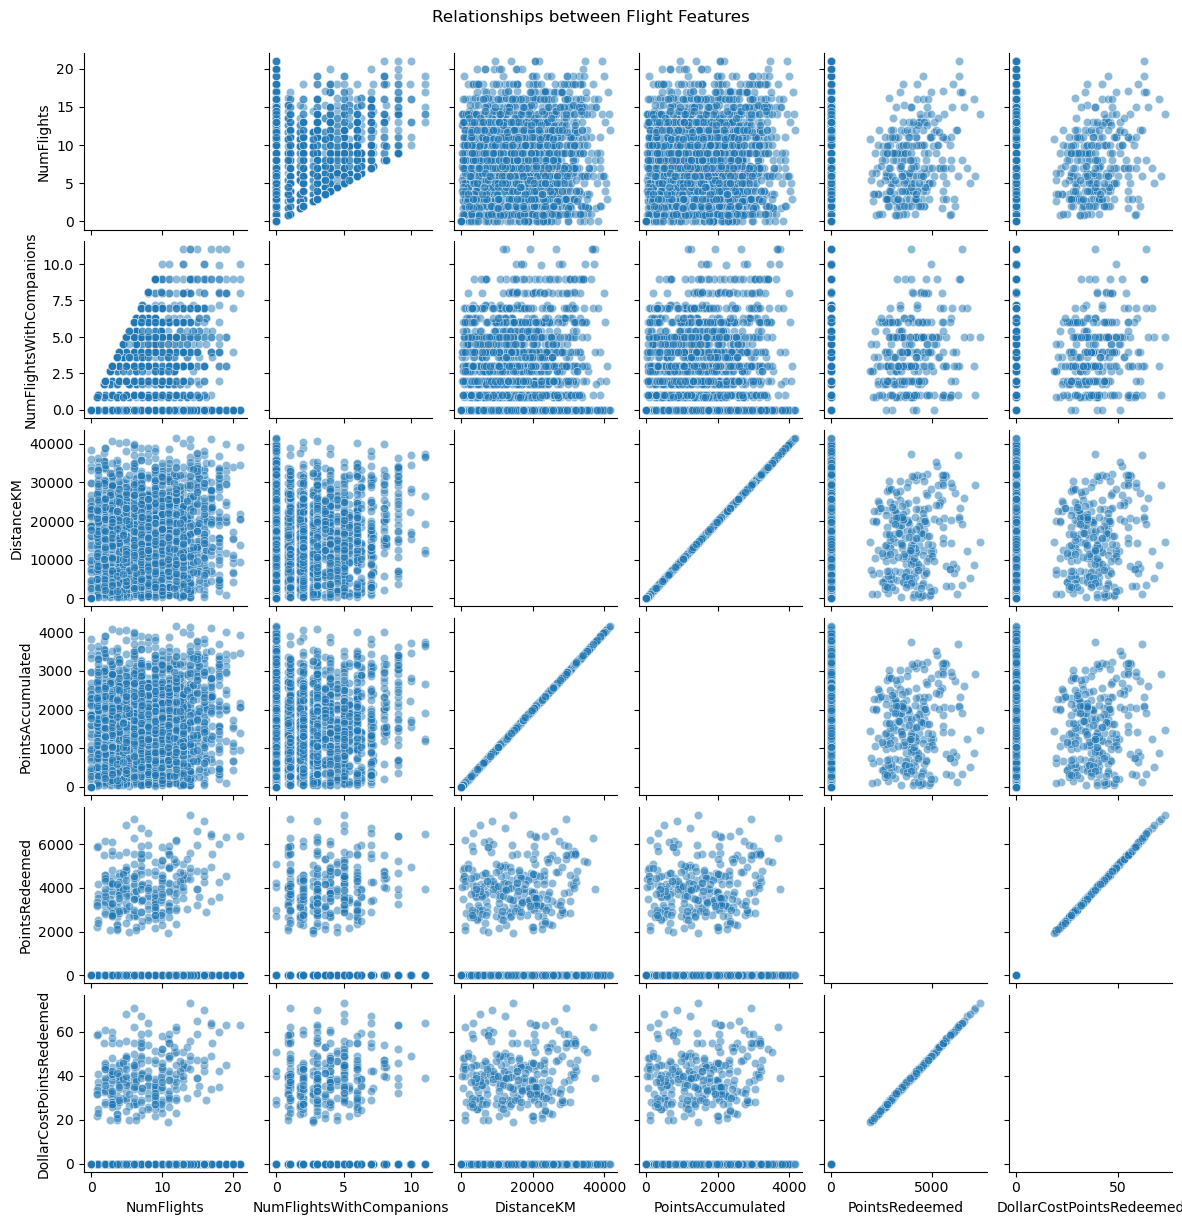

In [21]:
g = sns.pairplot(
    data=flights_db[numeric_features].sample(5000, random_state=42),
    diag_kind='scatter',      
    plot_kws={'alpha': 0.5},
    height=2
)

plt.suptitle('Relationships between Flight Features', y=1.02)
plt.show()

### Observations from the Scatter Plot

#### **Strong Linear Correlations**
- **DistanceKM and PointsAccumulated:**  
  There is a *nearly perfect linear correlation* between these two variables. This makes sense since loyalty programs typically award points proportional to the distance flown. The diagonal line pattern confirms this rule-based relationship.  
  → **Interpretation:** The more kilometers a customer flies, the more points they accumulate — a direct, systematic link rather than behavioral variation.

- **PointsRedeemed and DollarCostPointsRedeemed:**  
  This pair also shows a *perfect positive linear relationship*. The cost in dollars grows in direct proportion to the points redeemed.  
  → **Interpretation:** The airline’s redemption system consistently converts points to monetary value at a fixed rate, suggesting a stable and predictable reward conversion mechanism.

---

#### **Moderate Positive Trends**
- **NumFlights and DistanceKM / PointsAccumulated:**  
  Customers who take more flights generally cover more distance and accumulate more points, although with more variation than the linear cases above.  
  → **Interpretation:** Some customers may take many short flights, while others take fewer long ones — explaining the moderate rather than perfect correlation.

- **NumFlights and NumFlightsWithCompanions:**  
  There’s a clear positive association — passengers who fly more frequently also tend to fly more often with companions.  
  → **Interpretation:** This could indicate a segment of loyal customers who consistently travel with family, friends, or colleagues, possibly representing a valuable demographic for group travel promotions.

---

#### **Clustered Data Patterns**

- **Clustered distributions:**  
  For many features, data points appear concentrated in specific ranges (e.g., low flight counts, moderate distances).  
  → **Interpretation:** Most customers likely fly infrequently, while a smaller subset are heavy travelers. This skew could affect model training if not accounted for.

---

#### **Weak or Nonlinear Relationships**
- **PointsRedeemed and NumFlightsWithCompanions:**  
  No clear pattern is visible here, suggesting that redeeming points does not depend on whether the customer tends to fly alone or with companions.  
  → **Interpretation:** Redemption behavior might be more influenced by individual loyalty strategies, travel frequency, or availability of redemption opportunities.

- **DistanceKM and PointsRedeemed:**  
  The relationship seems weakly positive but scattered, implying that not all high-distance travelers redeem their points frequently.  
  → **Interpretation:** Some high-value customers may be accumulating points for larger future redemptions or are less engaged in reward usage.

---

#### **General Insights**
- The pair plot confirms logical relationships within the airline loyalty data — distance, flights, and accumulated points are strongly linked, while redemption behavior is more customer-specific.  
- The lack of strong cross-feature noise suggests data integrity is good. However, some discretization and clustering may require normalization for modeling or visualization purposes.  
- From a business perspective, segmenting customers based on flight frequency, distance traveled, and redemption patterns could yield meaningful insights for targeted marketing or retention strategies.


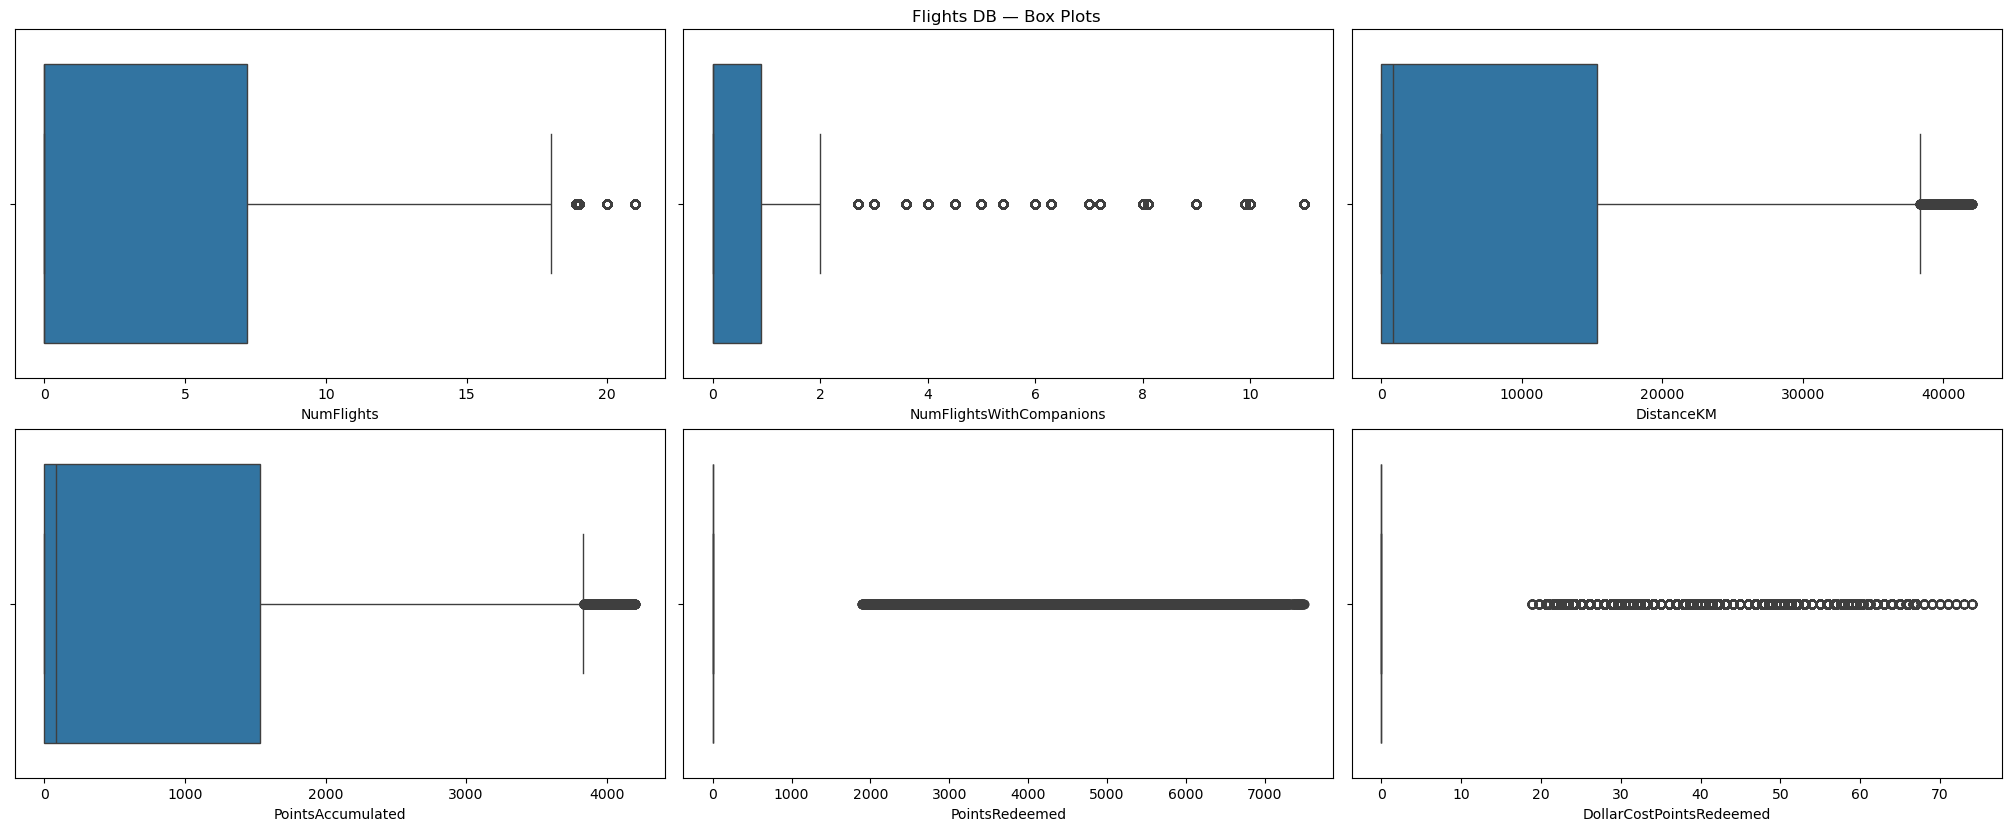

In [22]:
#checking boxplot 
fig, axes = plt.subplots(2, 3,figsize=(20, 8), constrained_layout=True)

for ax, feat in zip(axes.flatten(), numeric_features):
    sns.boxplot(data=flights_db, x=feat, ax=ax)
    ax.set_xlabel(feat)                           
    ax.set_ylabel('')        

fig.suptitle("Flights DB — Box Plots", y=1.02)
plt.show() 

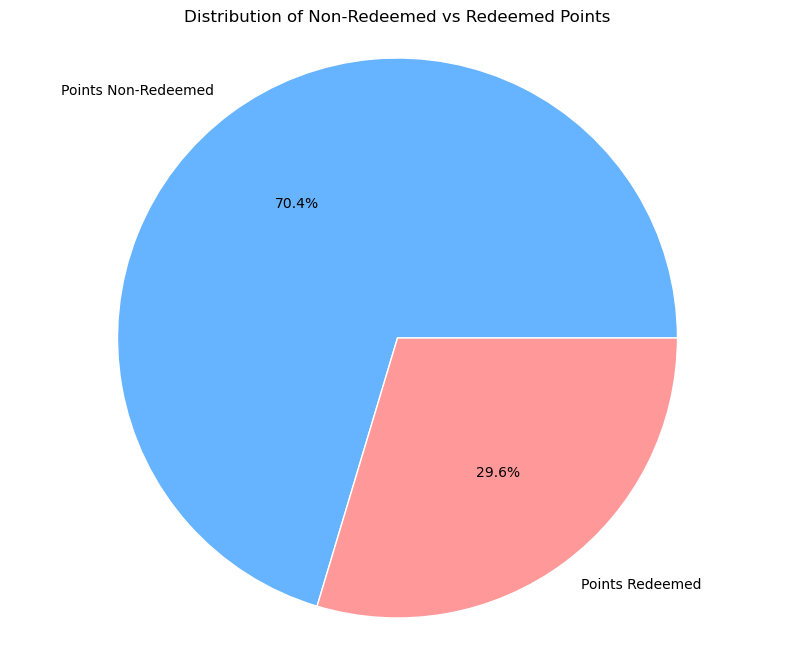

In [54]:
# Plot the distribution of non-redeemed vs redeemed points
points_accumulated = flights_db['PointsAccumulated'].sum()
points_redeemed = flights_db['PointsRedeemed'].sum()
points_non_redeemed = points_accumulated - points_redeemed

# Pie chart
fig, ax = plt.subplots(figsize=(10, 8))
sizes = [points_non_redeemed, points_redeemed]
labels = ['Points Non-Redeemed', 'Points Redeemed']
colors = ['#66b3ff', '#ff9999']

ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
       wedgeprops={"linewidth": 1, "edgecolor": "white"})

plt.title('Distribution of Non-Redeemed vs Redeemed Points')
plt.axis('equal')
plt.show()

## Correlation Matrix for the flights dataset

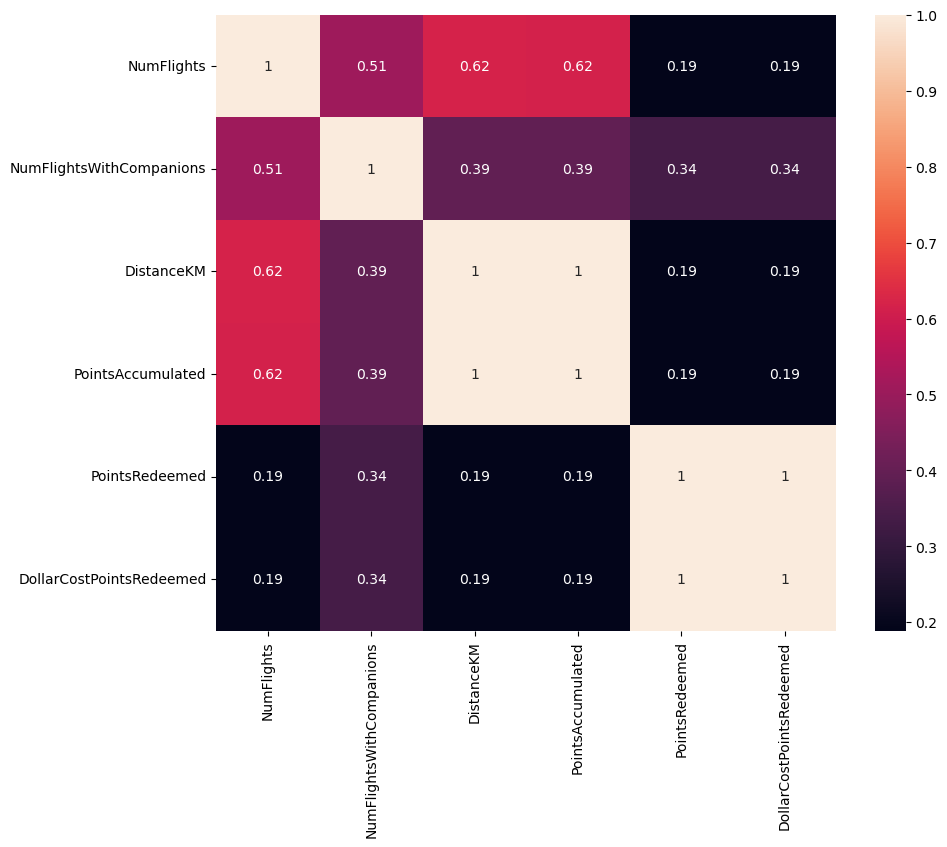

In [23]:
fig = plt.figure(figsize=(10, 8))

corr = flights_db[numeric_features].corr(method="pearson")

sns.heatmap(data=corr, annot=True, )


plt.show()

# Observations of the Correlation Matrix

| Pair | Correlation | Interpretation |
|------|--------------|----------------|
| NumFlights and DistanceKM | 0.62 | Strong positive — more flights generally means more total distance flown. |
| NumFlights and PointsAccumulated | 0.62 | Strong positive — more flights results in more points earned. |
| NumFlights and NumFlightsWithCompanions | 0.51 | Moderate positive — people who fly often also tend to fly with companions more. |
| NumFlightsWithCompanions and DistanceKM | 0.39 | Moderate — more companion flights slightly increase total distance. |
| PointsRedeemed and DollarCostPointsRedeemed | 1.00 | Perfect correlation — these two represent the same underlying concept (points redeemed vs. their dollar cost).
| PointsRedeemed and NumFlights / DistanceKM / PointsAccumulated | 0.19–0.34 | Weak relationships — redeeming points doesn’t strongly depend on flying behavior in this dataset. |


### Insights

The dataset splits into two main groups:

- **Flight activity metrics:**  
  `NumFlights`, `NumFlightsWithCompanions`, `DistanceKM`, `PointsAccumulated`

- **Redemption metrics:**  
  `PointsRedeemed`, `DollarCostPointsRedeemed`

---

- These two groups are weakly correlated with each other, suggesting that accumulating points and redeeming them behave independently.  

- The perfect correlation between `PointsRedeemed` and `DollarCostPointsRedeemed` indicates redundancy — there is only need to keep one of them (`PointsRedeemed`).



# <a id="preprocessing"></a> Preprocessing

In [24]:
# Remove duplicates in customer_db based on 'Loyalty#'
customer_db_cleaned = customer_db[~customer_db['Loyalty#'].isin(duplicated_loyalty_ids)]

# Remove duplicates in flights_db based on 'Loyalty#'
flights_db_cleaned = flights_db[~flights_db['Loyalty#'].isin(duplicated_loyalty_ids)]

# Number of records after removing duplicates
print(f'% of Customer DB records remaining: {round(customer_db_cleaned.shape[0] / customer_db.shape[0], 2)}')
print(f'% of Flights DB records remaining: {round(flights_db_cleaned.shape[0] / flights_db.shape[0], 2)}')

# Merge the cleaned dataframes
merged_db = customer_db_cleaned.merge(flights_db_cleaned, on='Loyalty#', how='inner')

# Check if the merge has the same number of rows as flights_db_cleaned
print(f'Number of records in merged DB: {merged_db.shape[0] == flights_db_cleaned.shape[0]}')

% of Customer DB records remaining: 0.98
% of Flights DB records remaining: 0.98
Number of records in merged DB: True


## <a id="missing-values"></a> Missing Values

In this step, we will create a simple helper function called missing_report() to check how many missing values exist in each column of both datasets: CustomerDB and FlightsDB. This will help us identify which features might need cleaning or imputation later. The function will return the total number of missing entries and their corresponding percentage, sorted from the highest to the lowest.

In [25]:
def missing_report(df: pd.DataFrame) -> pd.DataFrame:
    out = df.isna().agg(['sum', 'mean']).T
    out.columns = ['Total', 'Percentage']
    out['Percentage'] = (out['Percentage'] * 100).round(2)
    return out.sort_values(['Total', 'Percentage'], ascending=False)

In [26]:
customer_missing = missing_report(customer_db)
flights_missing  = missing_report(flights_db)

customer_missing

,Total,Percentage
CancellationDate,14611.0,86.35
Income,20.0,0.12
Customer Lifetime Value,20.0,0.12
Loyalty#,0.0,0.00
First Name,0.0,0.00
Last Name,0.0,0.00
Customer Name,0.0,0.00
Country,0.0,0.00
Province or State,0.0,0.00
City,0.0,0.00


In [27]:
flights_missing

,Total,Percentage
Loyalty#,0.0,0.0
Year,0.0,0.0
Month,0.0,0.0
YearMonthDate,0.0,0.0
NumFlights,0.0,0.0
NumFlightsWithCompanions,0.0,0.0
DistanceKM,0.0,0.0
PointsAccumulated,0.0,0.0
PointsRedeemed,0.0,0.0
DollarCostPointsRedeemed,0.0,0.0


After running the missing values report, we can see that the CancellationID column in the CustomerDB dataset has a very high proportion of missing values (around 86%). This actually makes sense: most customers likely never cancelled their membership or subscription, so this field would naturally remain empty for them.

Apart from that, only two other columns: Income and Customer Life have a very small number of missing records (around 0.12%), which is negligible. All other fields in CustomerDB, as well as every column in the FlightsDB dataset, are completely filled, showing that both datasets have excellent data quality overall.

## <a id="convert-data-types"></a> Convert data types